In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:
df_glob = pd.read_csv('AirPassengers.csv')
df_glob.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# В данных нет пропусков
print(df_glob.columns)
df_glob.info()

Index(['Month', '#Passengers'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df_glob['Month'] = pd.to_datetime(df_glob['Month'], format='%Y-%m')

In [5]:
display(df_glob.info())
df_glob.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


None

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
# Нам нужна информация за 1952 -- 1957 годы
df_glob.set_index('Month', drop=True, inplace=True)
df_glob.index.is_monotonic_increasing
df = df_glob['1952':'1957'] 

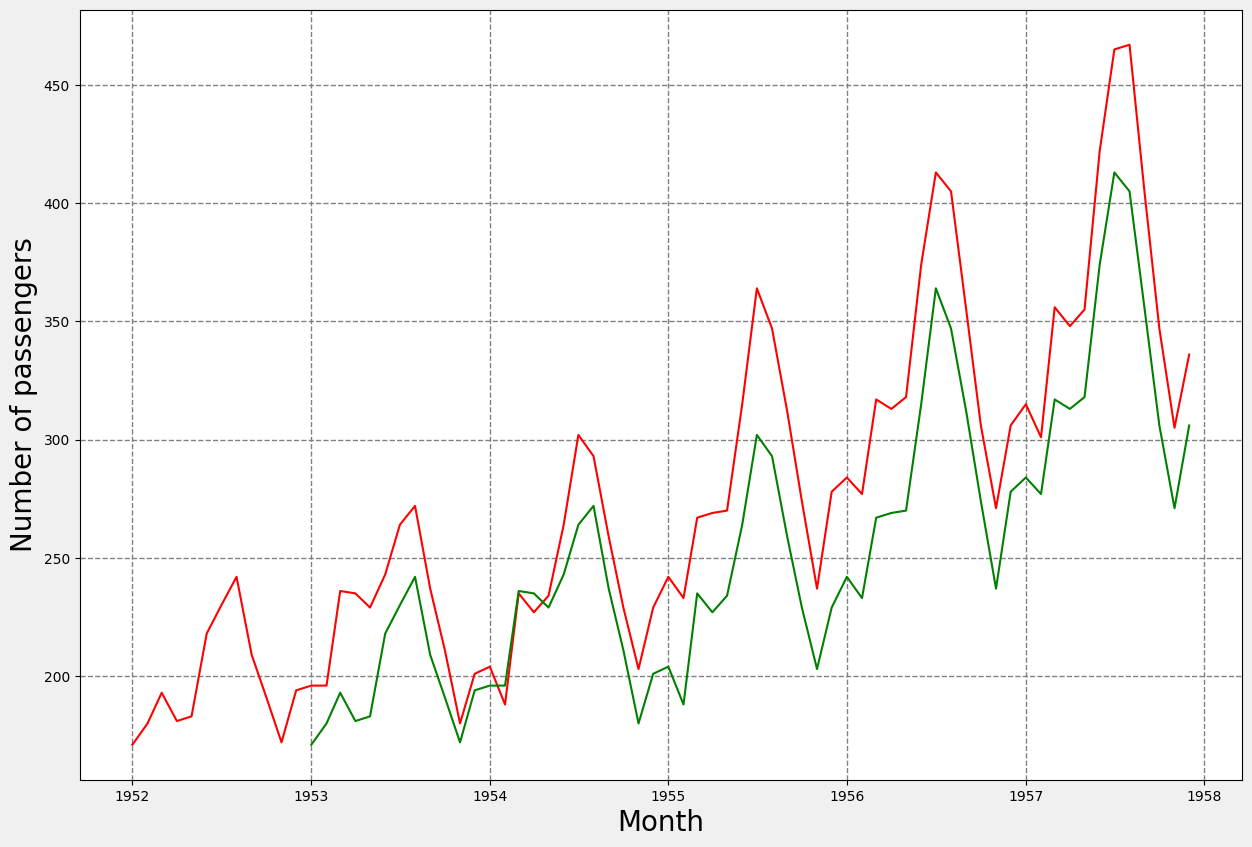

In [7]:
plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.plot(df, c='red')
plt.plot(df.shift(12), c='green')
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.show()

Перед применением seasonal_decompose опишем график. Мы видим ярко выраженную сезонность по годам (автокорреляция с лагом в год будет очень высокой), видим ярко выраженный пик в середине каждого года (логично предположить, что это связано с летними отпусками), а так же умеренный рост в конце и начале каждого года (что может быть связано с Рождеством/Новогодними каникулами).

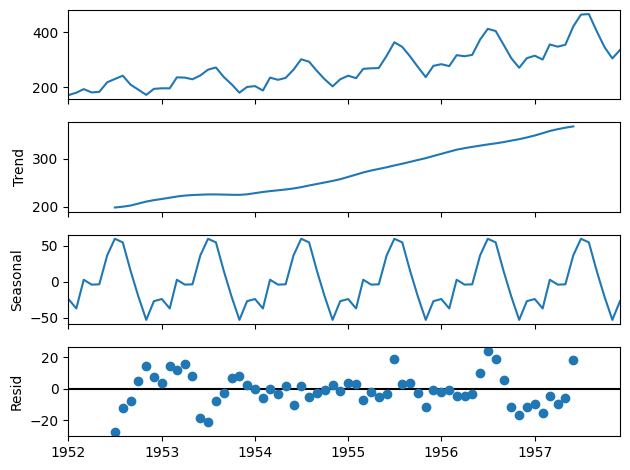

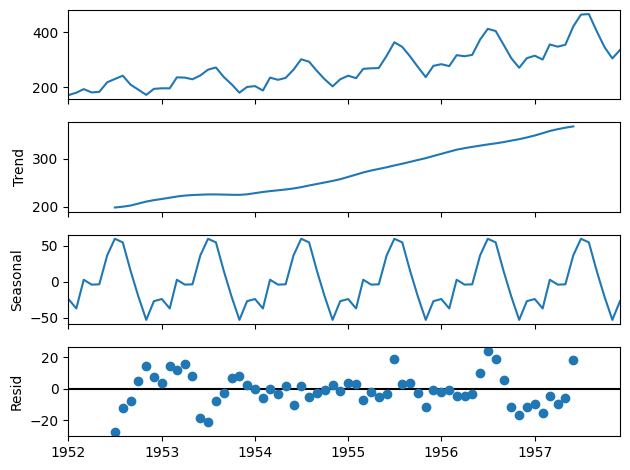

In [8]:
decomposed = seasonal_decompose(df)
decomposed.plot()

Мы видим общий тренд на увеличение числа пассажиров + сезонность, которую мы описали выше. В случае стационарных рядов тренда быть не должно, поэтому ряд не является стационарным.

In [9]:
acf = sm.tsa.acf(df)
acf

array([1.        , 0.89400793, 0.74549489, 0.61531598, 0.50234066,
       0.43030094, 0.38667   , 0.35354755, 0.35686359, 0.40011587,
       0.4555686 , 0.53720175, 0.58170785, 0.49625454, 0.37523856,
       0.27647025, 0.19148319, 0.13560224, 0.09421318])

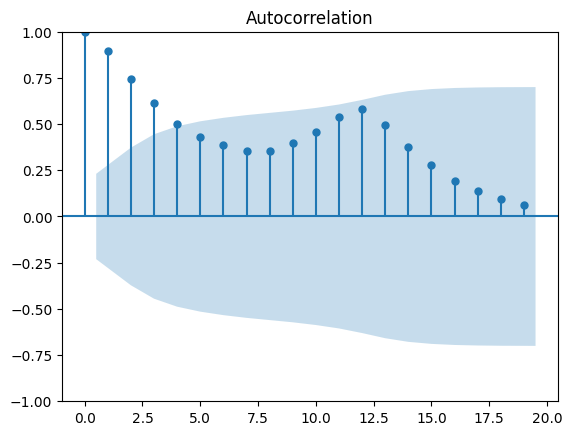

In [10]:
fig = tsaplots.plot_acf(df)
plt.show() 

Мы видим статистически значимую автокорреляцию на лагах в 1, 2 и 3 месяца (самая большая автокорреляция), что означает относительно 'плавное' изменение данных на горизонте 1-2-3 месяцев. Это говорит о ярко выраженной квартальной зависимости данных. Построим график автокорреляции для данных, сгруппированных по кварталам.

In [11]:
df_quart = df.resample('1Q').sum()

/tmp/ipykernel_511/4061547175.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quart = df.resample('1Q').sum()


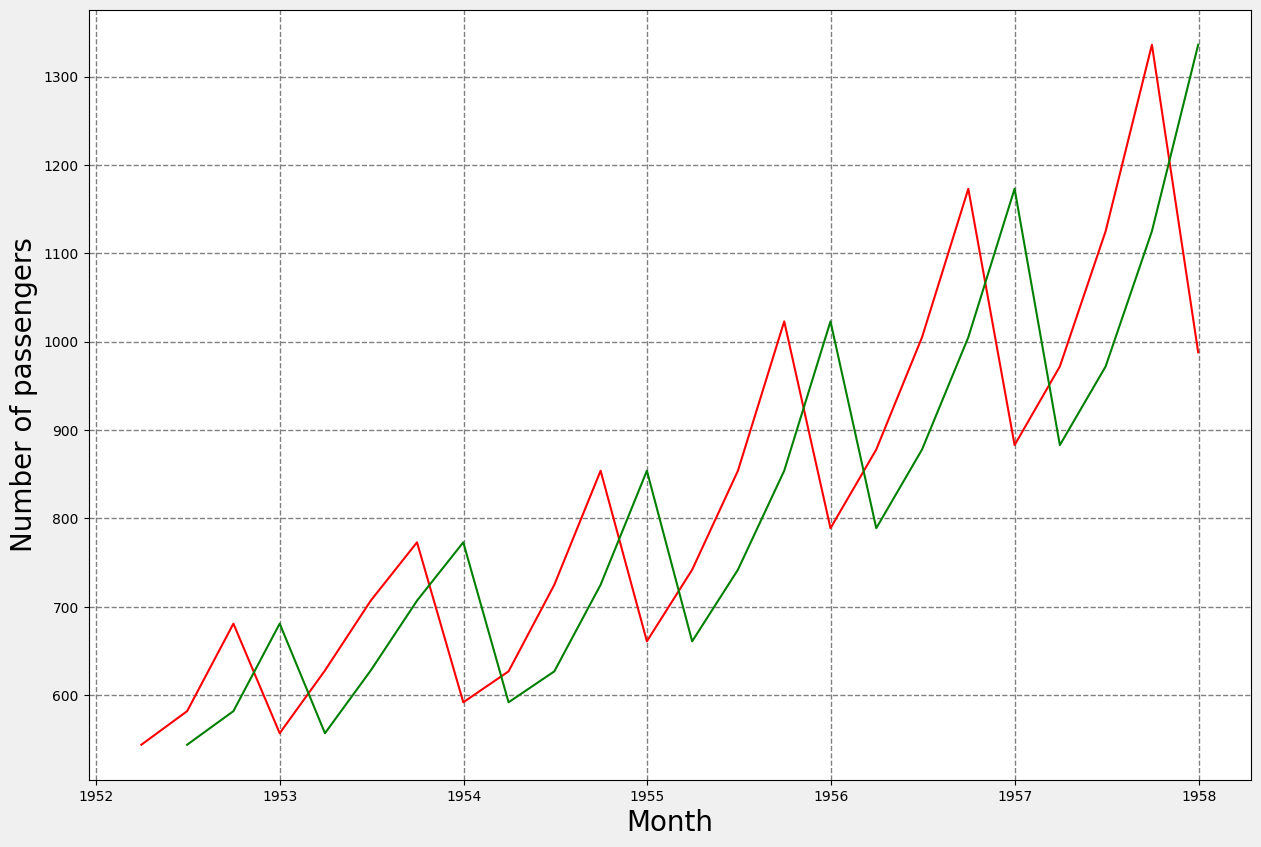

In [12]:
plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.plot(df_quart, c='red')
plt.plot(df_quart.shift(1), c='green')
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.show()

Здесь мы видим ярко выраженную зависимость -- первые 3 квартала показатель растёт, в последний падает + общий годовой тренд на увеличение.

In [13]:
acf = sm.tsa.acf(df_quart)
acf

array([ 1.        ,  0.66794418,  0.43681879,  0.43393778,  0.56843591,
        0.29932856,  0.11717392,  0.10887878,  0.18859104, -0.04282771,
       -0.19713568, -0.19203205, -0.13389464, -0.27737577])

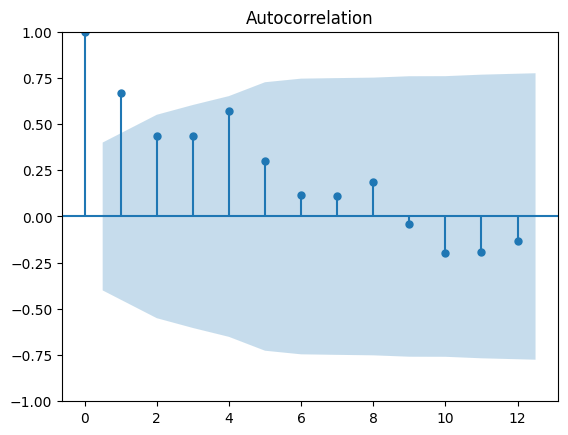

In [14]:
fig = tsaplots.plot_acf(df_quart)
plt.show() 

In [15]:
# Обучим линейную модель предсказывать значения нашего временного ряда

def generate_features(df, max_lag, max_rolling):
    ts = df.copy()

    for i in range(1, max_lag + 1, 1):
        ts[f'lag+{i}'] = ts['#Passengers'].shift(i)
    
    for j in range(1, max_rolling + 1):
        ts[f'rolling_{j}'] = ts['#Passengers'].rolling(j).mean().shift(j)

    return ts.dropna()
    


In [16]:

ml = 10
mr = 10

df_with_features = generate_features(df, ml, mr)

features = df_with_features.drop('#Passengers', axis = 1)
target = df_with_features['#Passengers']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=0, shuffle=False)

model = LinearRegression()
scaler = StandardScaler()

features_train_norm = scaler.fit_transform(features_train)
features_test_norm = scaler.transform(features_test)

model.fit(features_train_norm, target_train)
y_pred = model.predict(features_test_norm)
y_prev = target_test.shift(1).fillna(target_train.iloc[-1])

y_pred_train = model.predict(features_train_norm)
print(f'MAE для модели сдвига: {round(mean_absolute_error(y_prev, target_test), 1)}')
print(f'MAE для линейной модели на обучающей выборке: \
{round(mean_absolute_error(y_pred_train, target_train), 1)}')
print(f'MAE для линейной модели на тестовой выборке: {round(mean_absolute_error(y_pred, target_test), 1)}')


MAE для модели сдвига: 35.4
MAE для линейной модели на обучающей выборке: 8.3
MAE для линейной модели на тестовой выборке: 8.6


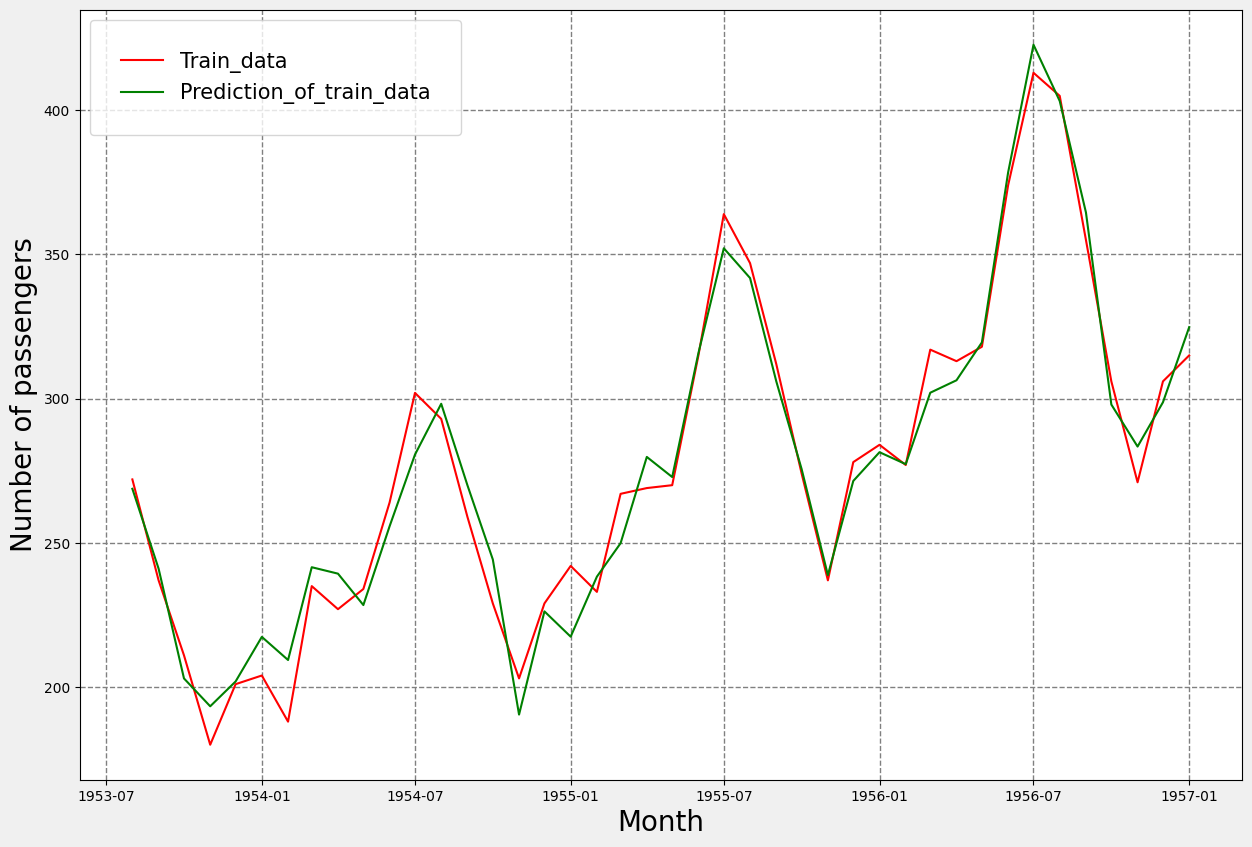

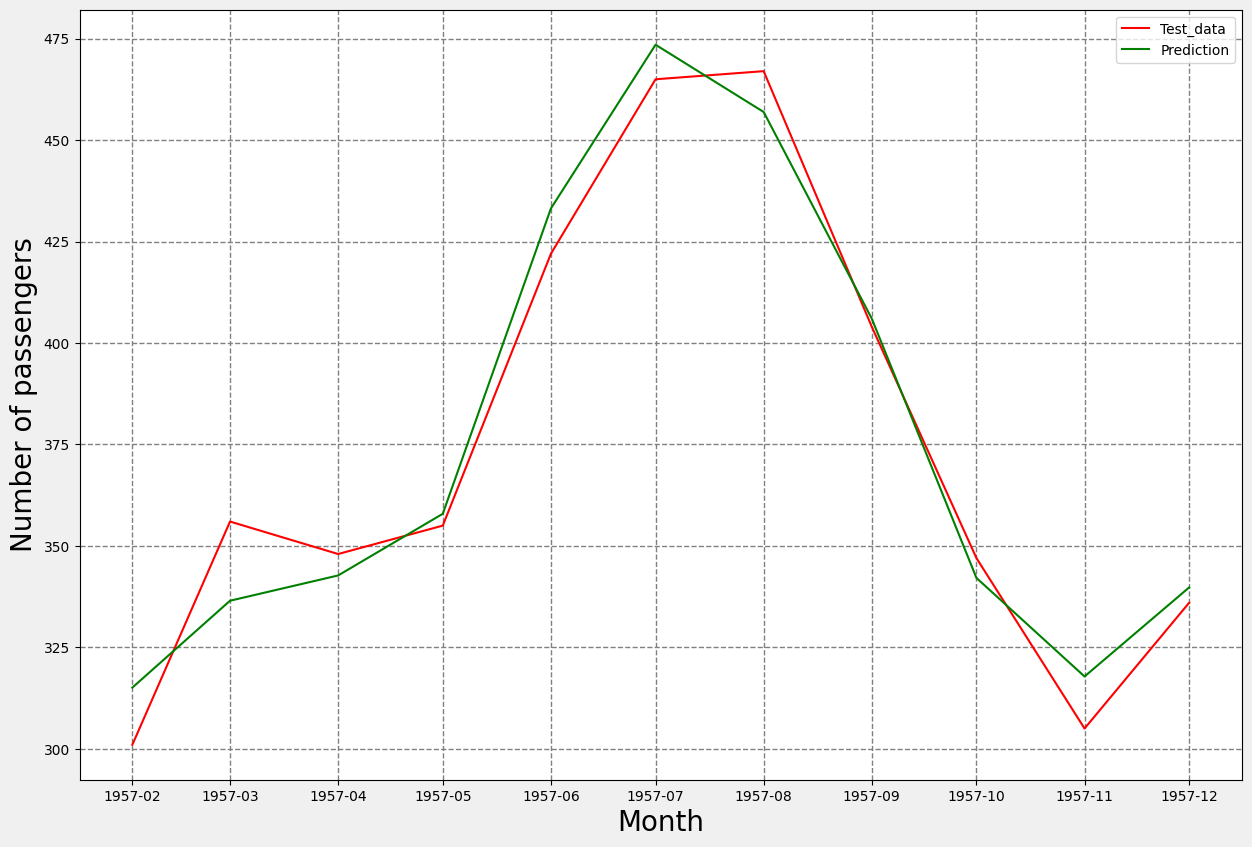

In [17]:
# Визуализируем получившиеся временные ряды
plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.plot(target_train, c='red', label = 'Train_data')
plt.plot(pd.Series(y_pred_train, index = target_train.index), c='green', label = 'Prediction_of_train_data')
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.legend(fontsize=15, borderpad=1.5)
plt.show()

plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.plot(target_test, c='red', label = 'Test_data')
plt.plot(pd.Series(y_pred, index = target_test.index), c='green', label = 'Prediction')
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.legend( )
plt.show()

In [18]:
# Посмотрим на важность фичей

pd.DataFrame(zip(features.columns, abs(model.coef_)), columns=['Feature', 'Importance']).sort_values(
    by='Importance', ascending=False)

,Feature,Importance
16,rolling_7,228.120671
17,rolling_8,171.404427
15,rolling_6,70.272456
9,lag+10,50.024577
7,lag+8,45.841062
2,lag+3,39.285471
6,lag+7,36.617484
3,lag+4,27.913191
5,lag+6,27.456389
19,rolling_10,26.456600


In [19]:
# Схитрим немного и сначала обработает весь датафрейм, а потом возьмём срез

ts = generate_features(df_glob, mr, ml)
ts = ts['1958':'1960']
ts_features = ts.drop('#Passengers', axis = 1)
ts_target = ts['#Passengers']

ts_features_norm = scaler.transform(ts_features)
y_pred_58_60 = model.predict(ts_features_norm)
print(f'MAE: {round(mean_absolute_error(y_pred_58_60, ts_target), 1)}')

MAE: 17.8


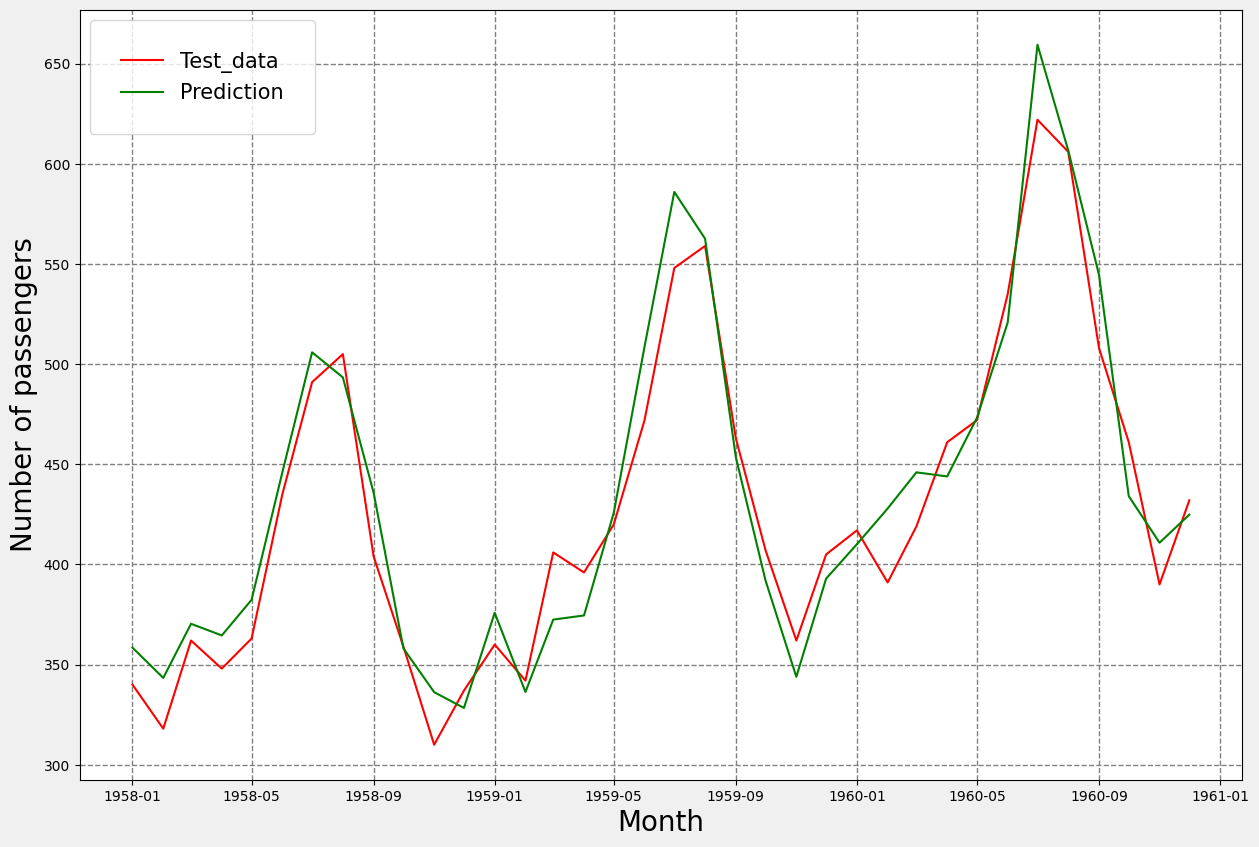

In [20]:
# Визуализация

plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.plot(ts_target, c='red', label = 'Test_data')
plt.plot(pd.Series(y_pred_58_60, index = ts_target.index), c='green', label = 'Prediction')
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.legend(fontsize=15, borderpad=1.5)
plt.show()